In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os

import keras
from keras.models import Model, load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from dataloader import trainGenerator, validGenerator
from model_9_layer_GSLRE import build_model_GSLRE

Using TensorFlow backend.


In [2]:
rootDir='./data/image_data'
trainDir = os.path.join(rootDir, 'train')
validDir = os.path.join(rootDir, 'test')

classSize = 500

In [3]:
batchSize = 128
val_batchSize = 128
width, height = 96, 96

In [4]:
vg = validGenerator(validDir, val_batchSize, 96, 96)

Found 29894 images belonging to 500 classes.


In [5]:
tg = trainGenerator(trainDir, batchSize, 96, 96)

Found 104742 images belonging to 500 classes.


In [6]:
model = build_model_GSLRE(classSize)
# model.load_weights('model_weights_best_epoch20.hdf5')

In [7]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='model_origin_weights_best_epoch.hdf5',
                                               verbose = 0, save_best_only=True, monitor='val_acc')

In [8]:
for i in range(5):
    tens = i + 1
    Lrate = 0.1**tens
    print(Lrate)
    sgd = optimizers.SGD(lr=Lrate, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])
    history = model.fit_generator(tg, epochs=10, verbose=1,
                        validation_data=vg,
                        callbacks=[checkpointer])
    with open('history_epoch{}0.pickle'.format(tens), 'wb') as handler:
        pkl.dump(history.history, handler, protocol=pkl.HIGHEST_PROTOCOL)
# test_loss, test_acc = model.evaluate_generator(vg, verbose=1)

0.1
Epoch 1/10
819/819 [==============================] - 228s 278ms/step - loss: 1.8425 - acc: 0.5760 - val_loss: 0.9061 - val_acc: 0.7511
Epoch 2/10
819/819 [==============================] - 225s 275ms/step - loss: 0.4864 - acc: 0.8608 - val_loss: 1.2479 - val_acc: 0.6865
Epoch 3/10
819/819 [==============================] - 225s 275ms/step - loss: 0.3265 - acc: 0.9053 - val_loss: 0.6050 - val_acc: 0.8341
Epoch 4/10
819/819 [==============================] - 225s 275ms/step - loss: 0.2568 - acc: 0.9232 - val_loss: 0.3519 - val_acc: 0.9041
Epoch 5/10
819/819 [==============================] - 225s 275ms/step - loss: 0.2109 - acc: 0.9376 - val_loss: 0.9987 - val_acc: 0.7712
Epoch 6/10
819/819 [==============================] - 226s 275ms/step - loss: 0.1800 - acc: 0.9453 - val_loss: 0.2982 - val_acc: 0.9209
Epoch 7/10
819/819 [==============================] - 225s 275ms/step - loss: 0.1533 - acc: 0.9536 - val_loss: 0.2861 - val_acc: 0.9254
Epoch 8/10
819/819 [========================

In [8]:
bvg = validGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.


In [10]:
test_model = build_model_GSLRE(classSize)
test_model.load_weights('model_origin_weights_best_epoch.hdf5')
test_model.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

test_loss, test_acc = test_model.evaluate_generator(vg, verbose=1)
test_loss, test_acc

234/234 [==============================] - 22s 94ms/step


(0.1600443010034071, 0.9598916170508868)

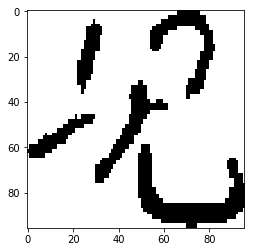

In [16]:
from scipy.ndimage import binary_dilation
temp = vg[85][0][0]
# temp = (temp - temp.min())/ np.ptp(temp)
# print(temp.min())
# plt.imshow(temp.reshape(96,96), cmap='gray')
plt.imshow(temp.reshape(96,96), cmap='gray')

In [9]:
k=4
b = 0.1**k
b

0.00010000000000000002